In [1]:
import pandas as pd
from datetime import datetime, timedelta
import requests

### Generating dynamic url based on today's date

In [2]:
def get_seismic_data(base_url, min_magnitude=3.5):
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = datetime.today() - timedelta(days=365)  # Initial guess (1 year back)
    
    while True:
        url = f"{base_url}?format=geojson&starttime={start_date.strftime('%Y-%m-%d')}&endtime={end_date}&minmagnitude={min_magnitude}"
        response = requests.get(url)
        data = response.json()
        
        if 'features' in data and len(data['features']) > 2000:
            start_date += timedelta(days=30)  # Move start date forward to reduce results
        else:
            break  # Found a valid range within the 2000 limit

    return url

base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
dynamic_url = get_seismic_data(base_url)
print("Generated API URL:", dynamic_url)

Generated API URL: https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2025-02-10&endtime=2025-03-17&minmagnitude=3.5


In [3]:
r = requests.get(dynamic_url)
data = r.json()
features = data['features']

features

[{'type': 'Feature',
  'properties': {'mag': 4.4,
   'place': 'Rat Islands, Aleutian Islands, Alaska',
   'time': 1742165181647,
   'updated': 1742175792040,
   'tz': None,
   'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us6000pz88',
   'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000pz88&format=geojson',
   'felt': None,
   'cdi': None,
   'mmi': 3.114,
   'alert': None,
   'status': 'reviewed',
   'tsunami': 0,
   'sig': 298,
   'net': 'us',
   'code': '6000pz88',
   'ids': ',ak0253geogr5,us6000pz88,',
   'sources': ',ak,us,',
   'types': ',origin,phase-data,shakemap,',
   'nst': 61,
   'dmin': 0.176,
   'rms': 0.57,
   'gap': 139,
   'magType': 'mb',
   'type': 'earthquake',
   'title': 'M 4.4 - Rat Islands, Aleutian Islands, Alaska'},
  'geometry': {'type': 'Point', 'coordinates': [178.2681, 51.8577, 107.977]},
  'id': 'us6000pz88'},
 {'type': 'Feature',
  'properties': {'mag': 5,
   'place': '136 km NW of San José de Jáchal, Argentina',
   't

In [4]:
earthquakes = []

for earthquake in features:
    properties = earthquake['properties']
    geometry = earthquake['geometry']

    earthquake_data = {
        'place':properties['place'],
        'mag': properties['mag'],
        'time': properties['time'],
        'tsunami': properties['tsunami'],
        'sig': properties['sig'],
        'latitude': geometry['coordinates'][1],
        'longitude': geometry['coordinates'][0],
        'depth': geometry['coordinates'][2],
    }

    earthquakes.append(earthquake_data)

In [5]:
earthquakes_df = pd.DataFrame(earthquakes)
earthquakes_df

,place,mag,time,tsunami,sig,latitude,longitude,depth
0,"Rat Islands, Aleutian Islands, Alaska",4.4,1742165181647,0,298,51.8577,178.2681,107.977
1,"136 km NW of San José de Jáchal, Argentina",5.0,1742161823898,0,385,-29.2552,-69.5850,108.690
2,"242 km WSW of Muxihe, China",4.2,1742160351328,0,271,33.2214,98.7161,10.000
3,"47 km SSE of Abomsa, Ethiopia",4.3,1742160016987,0,285,9.5647,40.0923,10.000
4,"45 km N of Āwash, Ethiopia",5.5,1742151189203,0,487,9.3942,40.2111,10.000
...,...,...,...,...,...,...,...,...
1217,"64 km WNW of Port-Vila, Vanuatu",4.9,1739147555149,0,369,-17.4939,167.7619,10.000
1218,"86 km SSE of Panguna, Papua New Guinea",5.4,1739147301215,0,449,-7.0809,155.6578,10.000
1219,"70 km WNW of Port-Vila, Vanuatu",5.3,1739146563322,0,433,-17.4323,167.7310,10.000
1220,"57 km WNW of Port-Vila, Vanuatu",5.3,1739146424708,0,432,-17.5144,167.8236,10.000


In [6]:
earthquakes_df["tsunami"].value_counts()

tsunami
0    1214
1       8
Name: count, dtype: int64

### Exploring numerical columns

In [7]:
for col in earthquakes_df.columns:
    print(f"Column: {col}")
    print(f"{col}: {earthquakes_df[col].describe()}")
    print("\n")
    

Column: place
place: count                          1222
unique                         1046
top       south of the Fiji Islands
freq                             30
Name: place, dtype: object


Column: mag
mag: count    1222.000000
mean        4.453249
std         0.432355
min         3.500000
25%         4.200000
50%         4.400000
75%         4.700000
max         6.500000
Name: mag, dtype: float64


Column: time
time: count    1.222000e+03
mean     1.740406e+12
std      8.578659e+08
min      1.739146e+12
25%      1.739635e+12
50%      1.740352e+12
75%      1.741016e+12
max      1.742165e+12
Name: time, dtype: float64


Column: tsunami
tsunami: count    1222.000000
mean        0.006547
std         0.080679
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: tsunami, dtype: float64


Column: sig
sig: count    1222.000000
mean      314.346154
std        76.245920
min       188.000000
25%       271.000000
50%       298.000000
7

In [8]:
## Formating 'time' column

earthquakes_df['datetime'] = pd.to_datetime(earthquakes_df['time'], unit='ms').dt.strftime("%B %d, %Y %H:%M")
earthquakes_df.drop("time", axis = 1, inplace=True)


In [9]:
def load_earthquake_data():
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = datetime.today() - timedelta(days=365)
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    min_magnitude = 3

    while True:
        url = f"{base_url}?format=geojson&starttime={start_date.strftime('%Y-%m-%d')}&endtime={end_date}&minmagnitude={min_magnitude}"
        response = requests.get(url)
        data = response.json()
        
        if 'features' not in data:
            raise ValueError("No 'features' key in the API response. Check the API URL or parameters.")
        
        if len(data['features']) <= 2000:
            break  # Exit the loop if the data is within the limit
        
        # Move start date forward to reduce results
        start_date += timedelta(days=30)

    features = data['features']
    earthquakes = []

    for earthquake in features:
        properties = earthquake['properties']
        geometry = earthquake['geometry']

        earthquake_data = {
            'place': properties['place'],
            'mag': properties['mag'],
            'time': properties['time'],
            'tsunami': properties['tsunami'],
            'sig': properties['sig'],
            'latitude': geometry['coordinates'][1],
            'longitude': geometry['coordinates'][0],
            'depth': geometry['coordinates'][2],
        }

        earthquakes.append(earthquake_data)
    
    earthquakes_df = pd.DataFrame(earthquakes)

    # Convert timestamp to datetime
    earthquakes_df['datetime'] = pd.to_datetime(earthquakes_df['time'], unit='ms').dt.strftime("%B %d, %Y %H:%M")
    # Drop unnecessary columns
    earthquakes_df.drop("time", axis = 1, inplace=True)

    return earthquakes_df

In [10]:
earthquakes_df =  load_earthquake_data()
earthquakes_df

,place,mag,tsunami,sig,latitude,longitude,depth,datetime
0,"Rat Islands, Aleutian Islands, Alaska",4.40,0,298,51.857700,178.268100,107.977,"March 16, 2025 22:46"
1,"136 km NW of San José de Jáchal, Argentina",5.00,0,385,-29.255200,-69.585000,108.690,"March 16, 2025 21:50"
2,"242 km WSW of Muxihe, China",4.20,0,271,33.221400,98.716100,10.000,"March 16, 2025 21:25"
3,"47 km SSE of Abomsa, Ethiopia",4.30,0,285,9.564700,40.092300,10.000,"March 16, 2025 21:20"
4,"45 km N of Āwash, Ethiopia",5.50,0,487,9.394200,40.211100,10.000,"March 16, 2025 18:53"
...,...,...,...,...,...,...,...,...
1396,"86 km SSE of Panguna, Papua New Guinea",5.40,0,449,-7.080900,155.657800,10.000,"February 10, 2025 00:28"
1397,"25 km W of Puerto Real, Puerto Rico",3.06,0,144,18.058333,-67.428333,2.680,"February 10, 2025 00:22"
1398,"70 km WNW of Port-Vila, Vanuatu",5.30,0,433,-17.432300,167.731000,10.000,"February 10, 2025 00:16"
1399,"57 km WNW of Port-Vila, Vanuatu",5.30,0,432,-17.514400,167.823600,10.000,"February 10, 2025 00:13"


In [11]:
earthquakes_df.columns

Index(['place', 'mag', 'tsunami', 'sig', 'latitude', 'longitude', 'depth',
       'datetime'],
      dtype='object')

In [12]:
earthquakes_df[['latitude', 'longitude']]

,latitude,longitude
0,51.857700,178.268100
1,-29.255200,-69.585000
2,33.221400,98.716100
3,9.564700,40.092300
4,9.394200,40.211100
...,...,...
1396,-7.080900,155.657800
1397,18.058333,-67.428333
1398,-17.432300,167.731000
1399,-17.514400,167.823600


### Tectonic Plates

In [13]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

In [14]:
# Load tectonic plate boundaries
plates = gpd.read_file("../data/PB2002_plates.json")

# Check the structure
plates.head()

,LAYER,Code,PlateName,geometry
0,plate,AF,Africa,"POLYGON ((-0.4379 -54.8518, -0.91466 -54.4535,..."
1,plate,AN,Antarctica,"POLYGON ((180 -65.7494, 180 -90, -180 -90, -18..."
2,plate,SO,Somalia,"POLYGON ((32.1258 -46.9998, 32.1252 -46.9975, ..."
3,plate,IN,India,"POLYGON ((56.2652 14.6232, 57.0015 14.6601, 57..."
4,plate,AU,Australia,"MULTIPOLYGON (((-180 -32.30415, -180 -15.62071..."


In [15]:
# Convert latitude/longitude into geometry
geometry = [Point(lon, lat) for lon, lat in zip(earthquakes_df['longitude'], earthquakes_df['latitude'])]
earthquakes_gdf = gpd.GeoDataFrame(earthquakes_df, geometry=geometry, crs="EPSG:4326")

# Perform spatial join to assign tectonic plates
earthquakes_with_plates = gpd.sjoin(earthquakes_gdf, plates, how="left", predicate="within")

In [16]:
# Rename columns
earthquakes_with_plates.rename(columns={"PlateName": "tectonic_plate"}, inplace=True)

# Drop unnecesary columns
earthquakes_with_plates.drop(["geometry", "index_right", "LAYER", "Code"], axis=1, inplace=True)

In [17]:
earthquakes_with_plates

,place,mag,tsunami,sig,latitude,longitude,depth,datetime,tectonic_plate
0,"Rat Islands, Aleutian Islands, Alaska",4.40,0,298,51.857700,178.268100,107.977,"March 16, 2025 22:46",North America
1,"136 km NW of San José de Jáchal, Argentina",5.00,0,385,-29.255200,-69.585000,108.690,"March 16, 2025 21:50",South America
2,"242 km WSW of Muxihe, China",4.20,0,271,33.221400,98.716100,10.000,"March 16, 2025 21:25",Eurasia
3,"47 km SSE of Abomsa, Ethiopia",4.30,0,285,9.564700,40.092300,10.000,"March 16, 2025 21:20",Africa
4,"45 km N of Āwash, Ethiopia",5.50,0,487,9.394200,40.211100,10.000,"March 16, 2025 18:53",Somalia
...,...,...,...,...,...,...,...,...,...
1396,"86 km SSE of Panguna, Papua New Guinea",5.40,0,449,-7.080900,155.657800,10.000,"February 10, 2025 00:28",Pacific
1397,"25 km W of Puerto Real, Puerto Rico",3.06,0,144,18.058333,-67.428333,2.680,"February 10, 2025 00:22",Caribbean
1398,"70 km WNW of Port-Vila, Vanuatu",5.30,0,433,-17.432300,167.731000,10.000,"February 10, 2025 00:16",New Hebrides
1399,"57 km WNW of Port-Vila, Vanuatu",5.30,0,432,-17.514400,167.823600,10.000,"February 10, 2025 00:13",New Hebrides


In [18]:
minor_to_major_plate = {
    "Juan de Fuca": "Pacific",
    "Okhotsk": "Eurasia",
    "Burma": "Eurasia",
    "Sunda": "Eurasia",
    "Yangtze": "Eurasia",
    "Amur": "Eurasia",
    "Aegean Sea": "Eurasia",
    "Caribbean": "North America",
    "Sandwich": "South America",
    "Nazca": "South America",
    "Cocos": "North America",
    "Panama": "North America",
    "Philippine Sea": "Pacific",
    "Tonga": "Pacific",
    "New Hebrides": "Pacific",
    "South Bismarck": "Pacific",
    "North Bismarck": "Pacific",
    "Mariana": "Pacific",
    "Kermadec": "Pacific",
    "Altiplano": "South America",
    "Maoke": "Australia",
    "Woodlark": "Australia",
    "Banda Sea": "Australia",
    "Okinawa": "Eurasia",
    "Futuna": "Pacific",
    "North Andes": "South America",
    "Arabia": "Eurasia",
    "Shetland": "Antarctica",
    "Manus": "Pacific",
    "Timor": "Australia",
    "Molucca Sea": "Pacific",
    "Balmoral Reef": "Australia",
    "Somalia": "Africa",
    "India": "Eurasia",
    "Birds Head": "Australia",
    "Easter": "Pacific",
    "Niuafo'ou": "Pacific",
    "Antarctica": "Antarctica",
}

# Assign major plate to each earthquake
earthquakes_with_plates["tectonic_plate"] = earthquakes_with_plates["tectonic_plate"].replace(minor_to_major_plate)

In [19]:
earthquakes_with_plates

,place,mag,tsunami,sig,latitude,longitude,depth,datetime,tectonic_plate
0,"Rat Islands, Aleutian Islands, Alaska",4.40,0,298,51.857700,178.268100,107.977,"March 16, 2025 22:46",North America
1,"136 km NW of San José de Jáchal, Argentina",5.00,0,385,-29.255200,-69.585000,108.690,"March 16, 2025 21:50",South America
2,"242 km WSW of Muxihe, China",4.20,0,271,33.221400,98.716100,10.000,"March 16, 2025 21:25",Eurasia
3,"47 km SSE of Abomsa, Ethiopia",4.30,0,285,9.564700,40.092300,10.000,"March 16, 2025 21:20",Africa
4,"45 km N of Āwash, Ethiopia",5.50,0,487,9.394200,40.211100,10.000,"March 16, 2025 18:53",Africa
...,...,...,...,...,...,...,...,...,...
1396,"86 km SSE of Panguna, Papua New Guinea",5.40,0,449,-7.080900,155.657800,10.000,"February 10, 2025 00:28",Pacific
1397,"25 km W of Puerto Real, Puerto Rico",3.06,0,144,18.058333,-67.428333,2.680,"February 10, 2025 00:22",North America
1398,"70 km WNW of Port-Vila, Vanuatu",5.30,0,433,-17.432300,167.731000,10.000,"February 10, 2025 00:16",Pacific
1399,"57 km WNW of Port-Vila, Vanuatu",5.30,0,432,-17.514400,167.823600,10.000,"February 10, 2025 00:13",Pacific


In [98]:
def get_tectonic_plate_data(earthquakes_df):
    
    plates = gpd.read_file("../data/PB2002_plates.json")

   # Convert latitude/longitude into geometry
    geometry = [Point(lon, lat) for lon, lat in zip(earthquakes_df['longitude'], earthquakes_df['latitude'])]
    earthquakes_gdf = gpd.GeoDataFrame(earthquakes_df, geometry=geometry, crs="EPSG:4326")

    # Perform spatial join to assign tectonic plates
    earthquakes_with_plates = gpd.sjoin(earthquakes_gdf, plates, how="left", predicate="within")

    # Rename columns
    earthquakes_with_plates.rename(columns={"PlateName": "tectonic_plate"}, inplace=True)

    # Drop unnecesary columns
    earthquakes_with_plates.drop(["geometry", "index_right", "LAYER", "Code"], axis=1, inplace=True)

    # Assign major plate to each earthquake
    earthquakes_with_plates["tectonic_plate"] = earthquakes_with_plates["tectonic_plate"].replace(minor_to_major_plate)
    
    return earthquakes_with_plates

In [21]:
earthquakes_with_plates = get_tectonic_plate_data(earthquakes_df)
earthquakes_with_plates

,place,mag,tsunami,sig,latitude,longitude,depth,datetime,tectonic_plate
0,"Rat Islands, Aleutian Islands, Alaska",4.40,0,298,51.857700,178.268100,107.977,"March 16, 2025 22:46",North America
1,"136 km NW of San José de Jáchal, Argentina",5.00,0,385,-29.255200,-69.585000,108.690,"March 16, 2025 21:50",South America
2,"242 km WSW of Muxihe, China",4.20,0,271,33.221400,98.716100,10.000,"March 16, 2025 21:25",Eurasia
3,"47 km SSE of Abomsa, Ethiopia",4.30,0,285,9.564700,40.092300,10.000,"March 16, 2025 21:20",Africa
4,"45 km N of Āwash, Ethiopia",5.50,0,487,9.394200,40.211100,10.000,"March 16, 2025 18:53",Africa
...,...,...,...,...,...,...,...,...,...
1396,"86 km SSE of Panguna, Papua New Guinea",5.40,0,449,-7.080900,155.657800,10.000,"February 10, 2025 00:28",Pacific
1397,"25 km W of Puerto Real, Puerto Rico",3.06,0,144,18.058333,-67.428333,2.680,"February 10, 2025 00:22",North America
1398,"70 km WNW of Port-Vila, Vanuatu",5.30,0,433,-17.432300,167.731000,10.000,"February 10, 2025 00:16",Pacific
1399,"57 km WNW of Port-Vila, Vanuatu",5.30,0,432,-17.514400,167.823600,10.000,"February 10, 2025 00:13",Pacific


## EDA

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
# Most recent seismic activity over 3.0 Mw registered
earthquakes_with_plates = earthquakes_with_plates.sort_values(by="datetime", ascending=False)
earthquakes_with_plates.iloc[0]

place             Rat Islands, Aleutian Islands, Alaska
mag                                                 4.4
tsunami                                               0
sig                                                 298
latitude                                        51.8577
longitude                                      178.2681
depth                                           107.977
datetime                           March 16, 2025 22:46
tectonic_plate                            North America
Name: 0, dtype: object

In [106]:
# Average magnitude by tectonic plate
avg_mag_by_plates = earthquakes_with_plates.groupby("tectonic_plate")["mag"].median().sort_values(ascending=False).reset_index()

# Rename the columns
avg_mag_by_plates = avg_mag_by_plates.rename(columns={"mag": "median_mag"})

# Apply background gradient styling (optional, for display in Jupyter Notebook)
styled_avg_mag_by_plates = avg_mag_by_plates.style.background_gradient(cmap='plasma')

# Display the styled DataFrame
styled_avg_mag_by_plates

,tectonic_plate,median_mag
0,Antarctica,4.750000
1,Caroline,4.600000
2,Africa,4.500000
3,South America,4.500000
4,Australia,4.400000
5,Eurasia,4.400000
6,Pacific,4.400000
7,Anatolia,4.200000
8,North America,3.610000


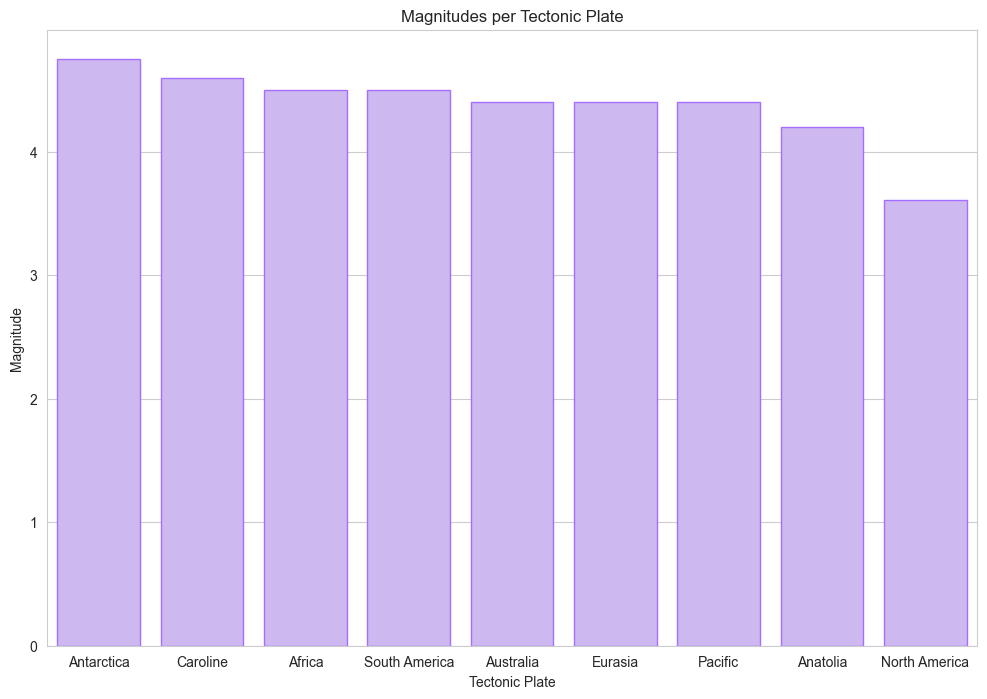

In [ ]:
# Define custom colors
color_blue = '#1192e8'
color_blue_light = sns.light_palette(color_blue, n_colors=2)[1]

color_purple = '#a56eff'
color_purple_light = sns.light_palette(color_purple, n_colors=3)[1] 

# Plot
plt.figure(figsize=(12, 8))
sns.catplot(x='tectonic_plate', y='median_mag', data=avg_mag_by_plates, color=color_purple_light, edgecolor=color_purple)
plt.title('Magnitudes per Tectonic Plate')
plt.xlabel('Tectonic Plate')
plt.ylabel('Magnitude')
plt.show()

In [122]:
# Top 10 seismic activity by magnitude and depth
earthquakes_with_plates[['place', 'tectonic_plate', 'mag', 'depth']].sort_values(by=["mag", "depth"], ascending=False).head(10).reset_index().drop(["index"], axis=1).rename(columns={"place": "Place", "tectonic_plate": "Tectonic Plate", "mag":"Magnitude (Mw)", "depth": "Depth (Km)"}).style.background_gradient(cmap='plasma')

,Place,Tectonic Plate,Magnitude (Mw),Depth (Km)
0,"36 km NNE of Olonkinbyen, Svalbard and Jan Mayen",Eurasia,6.500000,10.000000
1,"103 km WSW of San Pedro de Atacama, Chile",South America,6.100000,93.525000
2,"46 km E of Modisi, Indonesia",Eurasia,6.100000,13.331000
3,"86 km SE of Lata, Solomon Islands",Pacific,6.000000,36.000000
4,South Sandwich Islands region,South America,6.000000,35.379000
5,"4 km N of Metahāra, Ethiopia",Africa,5.900000,25.000000
6,"53 km WNW of Port-Vila, Vanuatu",Pacific,5.900000,18.000000
7,"Nicobar Islands, India region",Eurasia,5.900000,10.000000
8,"102 km NNE of Punta Cana, Dominican Republic",North America,5.850000,46.000000
9,"38 km ESE of Shingū, Japan",Eurasia,5.800000,394.464000


In [111]:
# Earthquake depth vs. Magnitude by tectonic plate
earthquakes_with_plates.groupby(['tectonic_plate']).agg(
    count=('mag', 'size'),
    mean_depth=('depth', 'mean'),  
    mean_magnitude=('mag', 'mean'), 
).sort_values(by=["mean_depth", "mean_magnitude"], ascending=False).reset_index()

,tectonic_plate,count,mean_depth,mean_magnitude
0,Australia,190,250.793595,4.470000
1,South America,139,95.679216,4.543165
2,Pacific,275,58.740858,4.303345
3,Eurasia,409,49.486858,4.476773
4,North America,328,34.866544,3.778476
5,Africa,42,12.608571,4.621429
6,Antarctica,16,10.000000,4.793750
7,Caroline,1,10.000000,4.600000
8,Anatolia,1,10.000000,4.200000


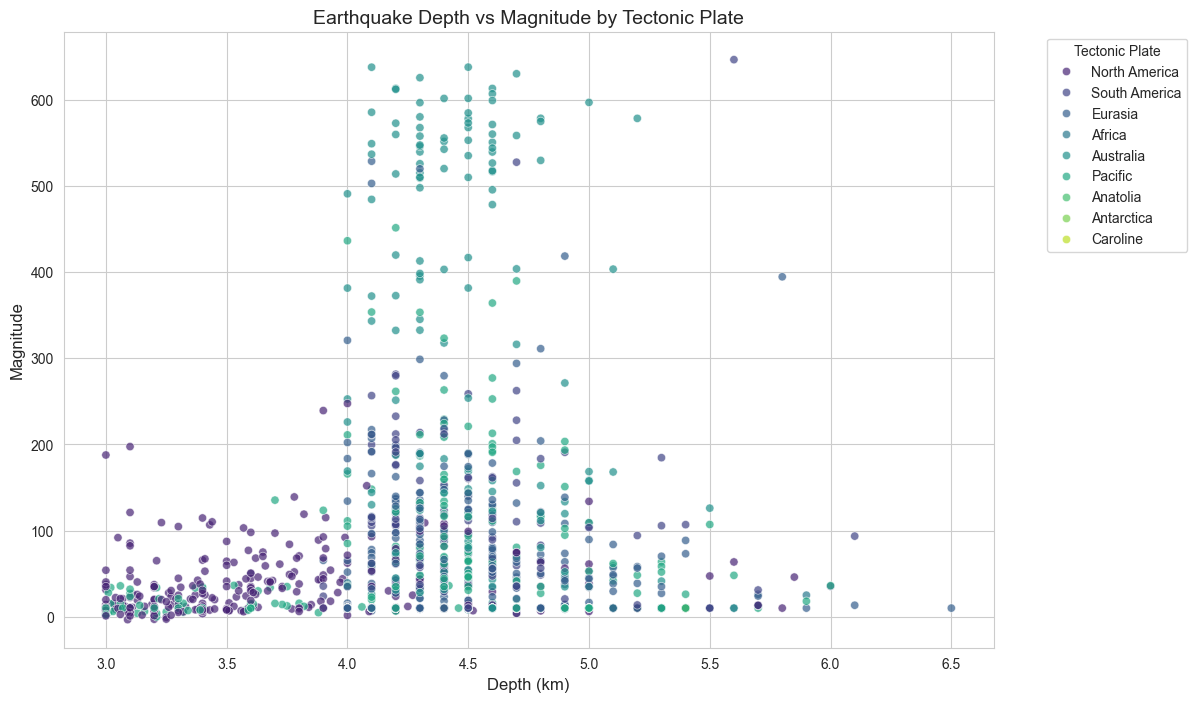

In [ ]:
# Set the style for the plot (optional)
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='depth',  # Depth on the x-axis
    y='mag',  # Magnitude on the y-axis
    hue='tectonic_plate',  # Color points by tectonic plate
    data=earthquakes_with_plates,  # Your DataFrame
    palette='viridis',  # Use a color palette (you can customize this)
    alpha=0.7,  # Transparency of points
    edgecolor='w',  # White edges around points
    linewidth=0.5  # Thickness of edges
)

# Add titles and labels
plt.title('Earthquake Depth vs Magnitude by Tectonic Plate', fontsize=14)
plt.xlabel('Depth (km)', fontsize=12)
plt.ylabel('Magnitude', fontsize=12)

# Add a legend
plt.legend(title='Tectonic Plate', bbox_to_anchor=(1.05, 1), loc='upper left')

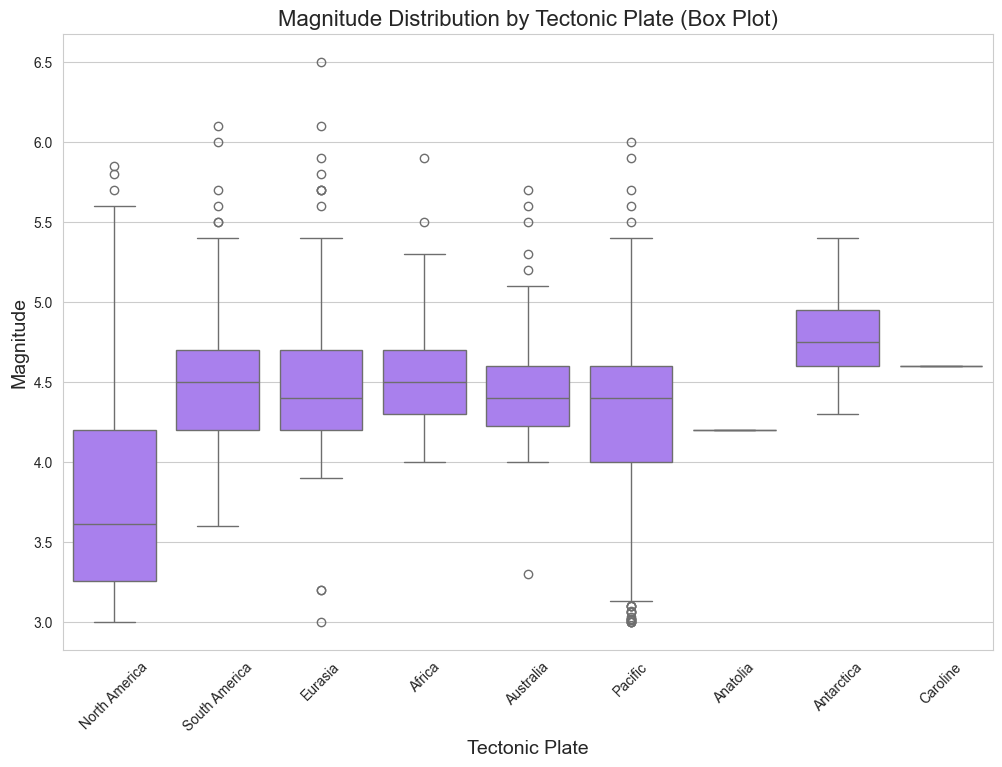

In [143]:
# Magnitude Distribution by Tectonic Plate

magnitude_by_plate = earthquakes_with_plates[['tectonic_plate', 'mag']]

# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='tectonic_plate', 
    y='mag', 
    data=magnitude_by_plate, 
    color=color_purple,
)

# Add titles and labels
plt.title('Magnitude Distribution by Tectonic Plate (Box Plot)', fontsize=16)
plt.xlabel('Tectonic Plate', fontsize=14)
plt.ylabel('Magnitude', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

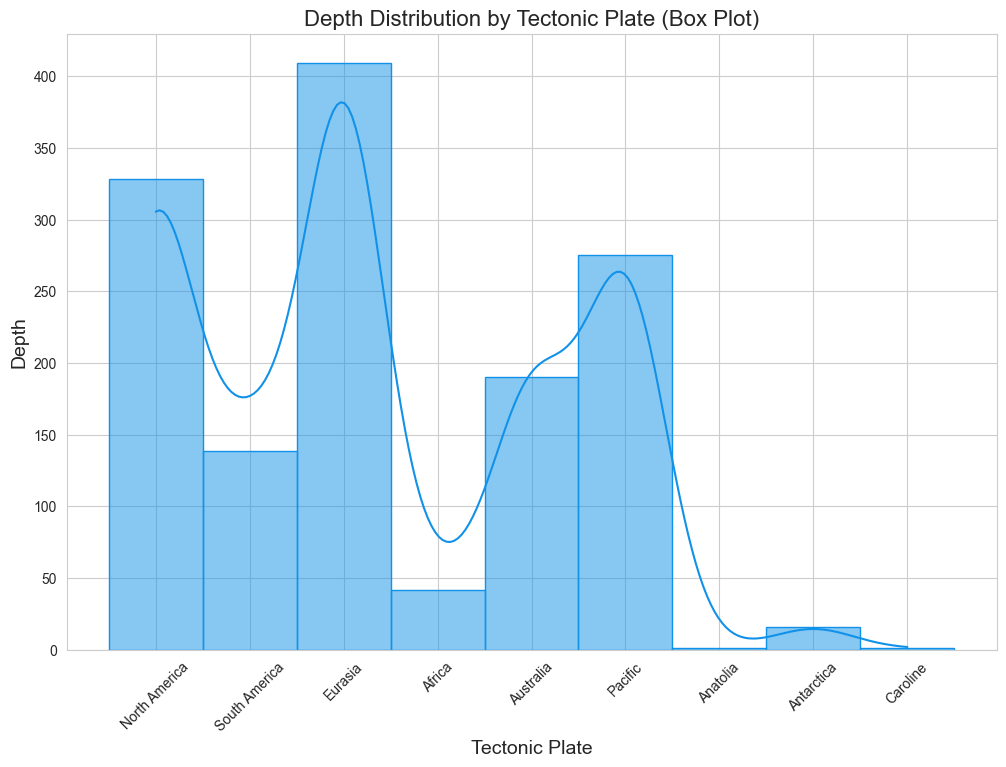

In [144]:
# Depth Distribution by Tectonic Plate

depth_by_plate = earthquakes_with_plates[['tectonic_plate', 'depth']]

# Create a box plot
plt.figure(figsize=(12, 8))
sns.histplot(
    x='tectonic_plate', 
    data=depth_by_plate,
    color=color_blue,
    edgecolor=color_blue_light,
    kde=True
)

# Add titles and labels
plt.title('Depth Distribution by Tectonic Plate (Box Plot)', fontsize=16)
plt.xlabel('Tectonic Plate', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

In [168]:
# HIGHEST AND LOWEST SEISMIC ACTIVITY AND THEIR MAGNITUDE

highest_depth = earthquakes_with_plates[['place','tectonic_plate', 'mag', 'depth']].sort_values(by="depth").head(10).reset_index(drop=True)
lowest_depth = earthquakes_with_plates[['place', 'tectonic_plate', 'mag', 'depth']].sort_values(by="depth", ascending=False).head(10).reset_index(drop=True)

display(highest_depth)
display(lowest_depth)

,place,tectonic_plate,mag,depth
0,"4 km WNW of Little America, Wyoming",North America,3.09,-3.40
1,"3 km NW of Little America, Wyoming",North America,3.20,-2.94
2,"2 km N of Little America, Wyoming",North America,3.25,-2.79
3,"11 km SW of Buttonwillow, CA",North America,3.25,-0.70
4,"31 km W of Petrolia, CA",Pacific,3.21,-0.11
5,"52 km S of Denali National Park, Alaska",North America,3.20,0.10
6,"47 km E of Fort Bidwell, California",North America,3.10,0.90
7,"46 km E of Fort Bidwell, California",North America,3.00,1.00
8,"44 km ENE of Fort Bidwell, California",North America,3.20,1.20
9,"50 km SSE of Lavrentiya, Russia",North America,4.00,1.60


,place,tectonic_plate,mag,depth
0,"118 km WNW of Iñapari, Peru",South America,5.6,646.456
1,south of the Fiji Islands,Australia,4.5,637.764
2,Fiji region,Australia,4.1,637.695
3,Fiji region,Australia,4.7,630.086
4,south of the Fiji Islands,Australia,4.3,625.499
5,"250 km E of Levuka, Fiji",Australia,4.2,613.028
6,Fiji region,Australia,4.6,613.026
7,south of the Fiji Islands,Australia,4.2,612.051
8,south of the Fiji Islands,Australia,4.6,606.869
9,Fiji region,Australia,4.5,601.502
